## Analyze degenerate barcodes
20221006 - Meant to be run after processing of unmapped reads (generated by CellRanger) using Picard / Samtools

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pysam
import scipy.stats

from Bio import SeqIO

np.random.seed(5)

In [2]:
hashes = {}
import csv
with open('barcodes.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    #first column forward, second column reverse complement
    for row in csvreader:
        if row[0].startswith("#"): continue
        hashes[row[0]] = row[2]

In [3]:
hashes

{'TGTCTAGT': 'shRenilla-1',
 'CTGAATCT': 'Myc (63)',
 'TTAATTAG': 'Onecut2 (76)',
 'CGGGAATG': 'Fosl2 (60)',
 'GCCTACGT': 'Fhl2 (61)',
 'GCCAATCG': 'Itga2 (1811)',
 'CGTTTCCT': 'Cldn4 (1999)',
 'ACACGTGA': 'Lif (2114)',
 'CAGTGCAT': 'Nfkb1 (2118)',
 'CGTTAGGG': 'Yap1 (65)',
 'CGTTCAAG': 'Nfkb2 (71)',
 'GGTAGGGA': 'Fosl1 (2115)',
 'ACAGAGCC': 'Relb (73) ',
 'GTACTTGC': 'patch4.4-1',
 'CCATTACT': 'patch4.4-2',
 'CATAGTCA': 'shRenilla-2',
 'TCTGGGGC': 'Atf4 (67)'}

In [4]:
#hashes = {"TGTCTAGT": "shRenilla", "CTGAATCT": "shMyc(63)", "TTAATTAG": "shOnecut2(76)"}
hashmatch = re.compile('GT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AA') #forward
#hashmatch = re.compile('TT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AC') #reverse complement

In [5]:
def hammingDistance(a, b):
    return sum(str1 != str2 for str1, str2 in zip(a, b))

In [6]:
#Changed this to actual experimental whitelist
import pickle
whitelist = set()
#open whitelist
with open('../write/cellwhitelist0.pickle', 'rb') as f:
    whitelist = pickle.load(f)

In [7]:
print(len(whitelist))

7114


In [8]:
import pickle
cellbyUMI = False
with open('cellbyUMI.pickle', 'rb') as f:
    cellbyUMI = pickle.load(f)

## IGNORE THIS

## END IGNORE

In [9]:
from IPython.core.debugger import set_trace

In [10]:
# first pass generate histogram of counts
histogram_of_counts = []
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        histogram_of_counts.extend(cellbyUMI[UMI][y].values())

By UMI/Cell


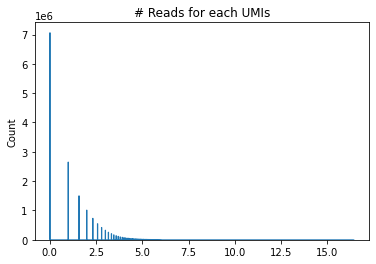

In [11]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
#cutoff = _[1][1]
#plt.axvline(x=cutoff)
plt.show()

In [12]:
count = 0
for x in range(0,len(_[1])):
    if x == 0: continue
    if round(_[1][x]) >= 1:
        count = x
        break

In [13]:
count

28

By UMI/Cell


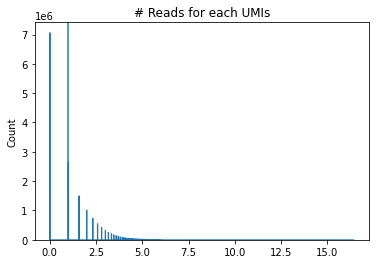

In [14]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff = round(_[1][count])
plt.axvline(x=cutoff)
plt.show()

In [15]:
cutoff = 2**(round(cutoff))
print(cutoff)

2


In [16]:
len(cellbyUMI)

7113

In [17]:
# Cleanup, prune any reads that don't pass the cutoff
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        toRemove = []
        for z in cellbyUMI[UMI][y]:
            if cellbyUMI[UMI][y][z] <= cutoff: toRemove.append(z)
        for z in toRemove:
            del cellbyUMI[UMI][y][z]
    toRemove = []
    for y in cellbyUMI[UMI]:
        if len(cellbyUMI[UMI][y]) == 0: toRemove.append(y)
    for y in toRemove:
        del cellbyUMI[UMI][y]
toRemove = []
for UMI in cellbyUMI:
    if len(cellbyUMI[UMI]) == 0: toRemove.append(UMI)
for UMI in toRemove:
    del cellbyUMI[UMI]

In [18]:
len(cellbyUMI)

6684

## second pass onwards

## end pass

In [20]:
## counting total UMIs from dominant shRNA
histogram_of_UMIs = []
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] > threshold: 
                ncellbyUMI[y] = newUMI[0][1]
            else:
                print("Not past threshold: %s" % str(newUMI))
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
        if newUMI[0][0] < threshold: continue
            
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]       
#        else:
#            print(newUMI)
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        continue            
            
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    histogram_of_UMIs.extend(UMIpairs.values())
    continue
    
    
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1:
        if list(UMIpairs.values())[0] < cutoff2: 
            print("Didn't pass cutoff2: %d, %s" % (cutoff2, str(UMIpairs)))
            continue        
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort(reverse=True)

    if newUMI[0][0] < cutoff2: 
        print("Not past UMI threshold: %s" % str(newUMI))
        continue
    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI if z[0] >= 5])

#    set_trace()
    if len(newUMI) == 2: # newUMI = [(count, (shRNAID, barcode)), ...]
        if newUMI[0][0] - newUMI[1][0] >= 3 and newUMI[1][0] <= 3:
            assignedCellshRNA[x] = newUMI[0][1][0]
            assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.10:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    else:
        set_trace()
    poorUMI.append(newUMI)
    poorUMI2.append(x)

[(4, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(7, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('CCATTACT', 'TATTTAAACGTTTTGTGTAAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GAGTTAATGTCTTTGGATGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CGTTAGGG', 'AGACCAAAGCTTTTACGTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GGTAGGGA', 'AAATTAAAGCAATTCCAATAA')), (3, ('CGTTTCCT', 'CCAGTAATTTAGTTTGTTTAA'))]
[(4, ('TGTCTAGT', 'TATTTAATT

[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'ATAACAACTGGGTTCCTTTAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (4, ('CAGTGCAT', 'GTGGAAATTT

[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('ACAGAGCC', 'GAATAAAGATGCTTCGAAGAA')), (3, ('CGTTCAAG', 'ATCTAAAAACTATTGTTTAAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TGTTGAATTATTTTGTTGTAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GTACTTGC', 'GTGGTAATCGACTTCTCACAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAA

[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGGAAGTGGGTTGGGGGAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('GGTAGGGA', 'CGCTGAATTTGATTGATAGAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('TTAATTAG', 'TAAAAAAAATAATTAAAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'TAATCAAGGACGTTATAGAAA'))]
[(5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA'))]
[(5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTT

[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('CCATTACT', 'AGGGAAAAGGAGTTAAAGAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA'))]
[(3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA'))]
[(7, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('GGTAGGGA', 'GTTTGAATGATCTTAGGAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(5, ('GGTAGGGA', 'GTTTGAATGATCTTAGGAGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('CGTTCAAG', 'GCAG

[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(3, ('TTAATTAG', 'GGCAGAAGATCGTTATAACAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TCTGGGGC', 'TTTTGAATTTTTTTTTTGTAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('GTACTTGC', 'GTGGTAATCGACTTCTCACAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(9, ('GGTAGGGA', 'TAATAAAATCACTTTTTAAAA')), (3, ('GGTAGGGA', 'AATTAAAATCACTTTTTTAAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGG

[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA'))]
[(5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTGTTTTGGTTAA'))]
[(6, ('CGGGAATG', 'GGATAAATGATGTTAGGAGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(7, ('GGTAGGGA', 'GTTATAAAAACATTAGGTTAA')), (3, ('ACACGTGA', 'GGGGGAA

[(5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTGTGTTAA')), (3, ('TTAATTAG', 'GGTGCAATGATGTTGCAAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CGTTAGGG', 'AATACAATAGTGTTTTGTTAA'))]
[(9, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (9, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (8, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (8, ('GGTAGGGA', 'ATAGCAAATGTTTTTCCAAAA')), (8, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (8, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (6, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (6, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (6, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCAATCG', 'CACATAAGAACC

[(3, ('TGTCTAGT', 'CGGGCAACTTCATTGATGTAA')), (3, ('CGTTAGGG', 'GATGTAACTTTTTTAGTCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(5, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GGTAGGGA', 'TAGGAAATCTGGTTCTATGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTACCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (5, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (4, ('GGTAGGGA', 'TATAGAACAGGGTTAATGTAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GTACTTGC', 'ATCTAAACGTGCTTTAATGAA')), (3, ('CGGGAATG', 'TTCTCAA

[(4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTACCCCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA')), (4, ('ACAGAGCC', 'GGTGAAACACCGTTAGGTGAA'))]
[(7, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CCATTACT', 'TGGTGAAG

[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GTGTTAACGGGTTTGGTGGAA')), (3, ('CGTTAGGG', 'GATGTAACTTTTTTAGTCCAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(8, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'GGCGCAAGGTTGTTGGAGGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(10, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (4, ('GCCTACGT', 'TCCTTA

[(4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'TGTTTAATTTTTTTTTCTGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(5, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(8, ('GGTAGGGA', 'GTGATAAAAACATTAGGTAAA')), (3, ('GGTAGGGA', 'GTTATAAA

[(7, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGTTCAAG', 'ATAACAACTGGGTTCCTTTAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'CCACCAACAAAATTACAAAAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA'))]
[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(6, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (4, ('TGTCTAGT', 'TATTTAATTTC

[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'TTTCAAATTTTGTTTTTTGAA'))]
[(6, ('CCATTACT', 'TGGTTAAGGTGGTTGGGGTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(7, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGAAA')), (3, ('TGTCTAGT', 'GGGGGAAATGATTTGGGAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(4, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('CGTTCAAG', 'ATAACAACTGGGTTCCTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGTGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(7, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TTTTAAA

[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('CGTTAGGG', 'GATGTAACTTTTTTAGTCCAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('CGGGAATG', 'CCCTCAATCGTTTTCTACCAA'))]
[(6, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTT

[(4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA'))]
[(4, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('TTAATTAG', 'GGCGGAATGATGTTGTGTTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TTAATTAG', 'TTTTTAAT

[(7, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'TAATTAACAGCATTGAATTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(12, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA')), (3, ('CGTTCAAG', 'CTAATA

[(9, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (9, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (8, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (8, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (7, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'TTTTTAATTATTTTTTTTTAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CTGAATCT', 'CCTGCAACACCCTTCCTCCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'ATCAGAATAATTTTGCATAAA'))]
[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('CGTTCAAG', 'TAAGAAATACAGTTACTGTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(6, ('TGTCTAGT', 'CACCCAACTCC

[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'ACAACAACGACATTACAATAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(8, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA'))]
[(3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(4, ('CCATTACT', 'TGGTG

[(6, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(8, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TTAATTAG', 'GGAGCA

[(8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA'))]
[(4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'GAATAAAGATGCTTCGAAGAA'))]
[(4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA'))]
[(4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'AAATA

[(8, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA')), (3, ('TTAATTAG', 'GGCGCAAGGTTGTTGGAGGAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(9, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('TTAATTAG', 'GGATGAACA

[(5, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('TTAATTAG', 'TGATTAATATTTTTCGATCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(4, ('TTAATTAG', 'TCATAAAAACCTTTCTATCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('TTAATTAG', 'TTATTAATTTTTTTTTTTCAA')), (3, ('TTAATTAG', 'TGTTCAATGATGTTGCAAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCAATCG', 'CACATAA

[(4, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('GTACTTGC', 'ATCTAAACGTGCTTTAATGAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(3, ('GTACTTGC', 'GTGGTAATCGACTTCTCACAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('CGTTCAAG', 'ATCTAAAAACGATTGTTTAAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA'))]
[(5, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('TGTCTAGT', 'GAGTTAATGTCTTTGGATGAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('TGTCTAGT', 'GAGTTAATGTCTTTGGATGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('CCATTACT', 'TTTTTAATTGTTTTTGAATAA'))]
[(4, ('GCCAATCG', 'CACA

[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(5, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (4, ('CCATTACT', 'TGGTTAAAGAGTTTTGGTAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAATGGGGTTGGGGGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTTTTATTAAAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (3, ('GCCTACGT', 'TCCTTAA

[(5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'TGGTAAATTATTTTATTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA')), (3, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA'))]
[(3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(6, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('TGTCTAGT', 'GGGGGAAGG

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('ACAGAGCC', 'CATTTAAGGGCTTTTGTACAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTGTTTTGGTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CCATTACT', 'TGGTTAAAGAGTTTTGGTAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(7, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CAGTGCAT', 'GTGGAAATATTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(9, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (6, ('CAGTGCAT', 'GTGGTAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CGTTCAAG', 'TATTCAAATA

[(8, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('TGTCTAGT', 'GGGGGAATGGGGTTGGGGGAA')), (4, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TGGTAAATTATTTTATTTTAA')), (3, ('TTAATTAG', 'GGAGCAATTA

[(8, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'TAACAAAAACAATTAATAAAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(4, ('CGTTAGGG', 'GTAATAATGAGGTTATGCGAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(9, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('ACACGTGA', 'TAGGCAAGGGGTTTGGTGGAA'))]
[(6, ('TGTCTAGT', 'GGGGGA

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('ACACGTGA', 'CAAAAAAAAATCTTGTAAAAA'))]
[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA'))]
[(11, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA'))]
[(5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TTAATTAG', 'GACGGAAG

[(4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'TTTCAAATTTTGTTTTTTGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(6, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('GGTAGGGA', 'ATAGCAAATGTTTTTCCAAAA'))]
[(5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(3, ('TGTCTAGT', 'TATTAAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (4, ('CGGGAATG', 'CCCCCAAC

[(6, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TTAATTAG', 'GGATTAATTTTTTTTCTTTAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TTAATTAG', 'TTTTTAATGATTTTTTTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA')), (3, ('CGTTAGGG', 'CATTTAATTTCGTTTTTGGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCC

[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(9, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(9, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (4, ('CGGGAATG', 'CCCCTAACCTCTTTCTCCAAA'))]
[(4, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'TAAGAAATACAGTTACTGTAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'TAAAAAAAGTGATTAGATAAA')), (3, ('TGTCTAGT', 'GGGGTAAG

[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGGGAAATGATTTGGGAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTG

[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TCTGGGGC', 'TTGTTAATTTTTTTTGGGTAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TTTTAAATTTTTTTTCTATAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
[(4, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(9, ('TTAATTAG', 'TTTTAAATTT

[(7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGAAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (4, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GTGGGAAGTTGGTTGGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GTACTTGC', 'GTGTTAATTAA

[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGTGGGAA'))]
[(8, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (6, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TTAATTAG', 'TTTTAAATTATTTTCTTTTAA')), (5, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (5, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (3, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (3, ('TGTCTAGT', 'ACTCGAAACGGGTTGGGGCAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GGTAGGGA', 'GGCACAACTTTGTTATTAAAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('CCATTACT', 'ACGTTAATAGTA

[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('TGTCTAGT', 'TATTTAATTTGTTTTGGTTAA'))]
[(4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('GGTAGGGA', 'GTGTAAATAAGATTTTAGGAA')), (3, ('GGTAGGGA', 'ATAGCAAATGTTTTTCCAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'TCGTTA

[(5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA'))]
[(4, ('TGTCTAGT', 'TCTTGAATTGTTTTTTTTTAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('GTACTTGC', 'GTGGTAATCGACTTCTCACAA'))]
[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(4, ('GCCTACGT', 'TCCTTAAG

[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'CACACAAGAAGATTAAAAAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(9, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(7, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (7, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (5, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'GAGGTAAACATGTTTTAGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGT

[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGTGTTGGGAAAA'))]
[(9, ('TGTCTAGT', 'CATACAATCGTTTTATTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('ACAGAGCC', 'TACGCAATCGAGTTGACCTAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(4, ('TGTCTAGT', 'CATACAATCGTTTTATTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(6, ('TGTCTAGT', 'CATACAATCGTTTTATTTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CGGGAATG', 'AGCCC

[(8, ('TTAATTAG', 'ACGAAAAACGAATTAAAGAAA')), (3, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (5, ('ACAGAGCC', 'TACGCAATCGAGTTTACCAAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (3, ('ACAGAGCC', 'ACTGGAAA

[(3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(9, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TTAATTAG', 'GGATTAATTTATTTTCTTTAA')), (4, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(3, ('TTAATTAG', 'TGAGGAAA

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'TCATAAAAACCTTTCTATCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(4, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GTGGGAAGTTGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TACACAAATTGGTTGTATGAA')), (3, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(8, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
[(5, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAA

[(4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('TTAATTAG', 'TTTTAAATTATTTTCTTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'AACAAAATACAATTCCAAAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTTAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(3, ('GGTAGGGA', 'GAGGAAATTTACTTAGTCTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTGTAATTAATTTTTTTTAA'))]
[(3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('GCCAATCG', 'CACATA

[(6, ('CGGGAATG', 'CACACAAGAAGATTAAAAAAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('GGTAGGGA', 'GTTTGAATGATCTTAGGAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(3, ('GCCAATCG', 'CACATAAGAA

[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CGGGAATG', 'TTTTTAAGGGTTTTTGGTGAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(3, ('TCTGGGGC', 'TTTTGAATTTTTTTTTTGTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CCATTACT', 'AGGGAAAAGGAGTTAAAGAAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('CGTTCAAG', 'TGTTTAATGCATTTTCTTGAA'))]
[(3, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(3, ('TGTCTAGT', 'CCCC

[(8, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('ACACGTGA', 'TGTTTAATTTTTTTTTCTGAA'))]
[(4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('CGTTAGGG', 'AGACCAAAGCTTTTACGTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(5, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA'))]
[(3, ('TTAATTAG', 'TCCCTAAAATCCTTCCATCAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(9, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (7, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'GGGGGA

[(7, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (7, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (4, ('CGGGAATG', 'CCCCCAACCTCCTTCCCCCAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('TTAATTAG', 'TGGTAAATTATTTTATTTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'GGTGCAATGATGTTGCAAGAA')), (3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGAGTTGGAGAAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGTTCAAG', 'TAATTAACAGCATTGAATTAA')), (3, ('CGTTAGGG', 'AGACCAAAGCTTTTACGTCAA')), (3, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGT

[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'TGATTAATATTTTTCGATCAA')), (3, ('GTACTTGC', 'TCGTTAAGAGGGTTCTCGCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CGTTCAAG', 'GAGGTAAACATGTTTTAGTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(5, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'ACAACAAAA

[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(6, ('TGTCTAGT', 'GGGTGAAGGGAGTTGGGATAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TGTCTAGT', 'GGGTGAAGGGAGTTGGGATAA')), (3, ('ACAGAGCC', 'CTTTTAATCGGGTTTGTTCAA'))]
[(5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('CGTTTCCT', 'AATTCAAGTACATTCTGTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA'))]
[(6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'GGGGGAAG

[(5, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (5, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('GGTAGGGA', 'ATAGCAAATGTTTTTCCAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('ACAGAGCC', 'ATCAGAATAATTTTGCATAAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('GCCAATCG', 'CACAGAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('CGTTCAAG', 'GAGGTAAACAT

[(3, ('GGTAGGGA', 'TAGGAAATCTGGTTCTATGAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'CCCCCAACCTCCTTCCCCCAA')), (3, ('CGGGAATG', 'AACCCAACCCCCTTCCCCCAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'AGGTGAAC

[(3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'AGCCCAACCC

[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (4, ('ACACGTGA', 'GGGGGAAAGGGATTGTGTGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(7, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('GGTAGGGA', 'GTTATAAAAACATTAGGTTAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGG

[(9, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (8, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA'))]
[(5, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(9, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(3, ('TTAATTAG', 'GGCGGAATGATGTTGTGTTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'GTGGAAA

[(6, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (5, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('CGTTAGGG', 'GTAATAATGAGGTTATGCGAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA'))]
[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('TTAATTAG', 'TCCGAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'GAGAAAAAAAAATTAGCAGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(4, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (3, ('TTAATTAG', 'TTTTTAAT

[(9, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (9, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (8, ('TTAATTAG', 'GGATTAATTTTTTTTCTGTAA')), (7, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (7, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (6, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('GTACTTGC', 'ATCTAAACGTGCTTTAATGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CGTTAGGG', 'TCAGCAATCATTTTCGCTCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTATTTGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CGTATAATTTTTTTATGTGAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGG

[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'GGGGTAATGTGGTTTGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(9, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(3, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TTAATTAG', 'GGCGGAATGATGTTGTGTTAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'GGGGG

[(8, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA')), (4, ('TTAATTAG', 'TTTGTAATTAATTTTTTTTAA')), (4, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(5, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'CGTATAATTTTTTTATGTGAA')), (3, ('CGTTAGGG', 'GTAATAATGAGGTTATGCGAA')), (3, ('CGTTAGGG', 'CATTTAATTTCGTTTTTGGAA')), (3, ('CGTTAGGG', 'AATACAATAGTGTTTTGTTAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(8, ('ACACGTGA', 'CCCCCAATG

[(4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTGTTTTGGTTAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CCATTACT', 'TGGTGAAGG

[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(9, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (8, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (8, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (7, ('TTAATTAG', 'TTTTCAATGTTTTTATTTTAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (5, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('ACAGAGCC', 'GAATAAAGATGCTTCGAAGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTCAAG', 'CTAATAACAACA

[(6, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(9, ('GGTAGGGA', 'AGAGAAAAGTGTTTGCTTAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('ACACGTGA', 'TGTTTAATTTTTTTTTCTGAA'))]
[(6, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTGTTGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'ACAACAACGACATTACAATAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGTTCAAG', 'TAATTAACA

[(5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('CGTTCAAG', 'TATCGAACTCTATTCAAGTAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA')), (3, ('GGTAGGGA', 'GAGGAAATTTACTTAGTCTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA'))]
[(7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CTGAATCT', 'ACAACAAAAA

[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'TAAAAAAAGTGATTAGATAAA')), (3, ('CGTTTCCT', 'AGAGAAAATACGTTGTTCGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CGTTCAAG', 'TAAGAAATACAGTTACTGTAA'))]
[(6, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGGGAATG', 'GTCTCAACGCCTTTTTCCCAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TTAATTAG', 'TGATTAATATTTTTCGATCAA')), (3, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (3, ('GTACTTGC', 'ATCTAAACGTGCTTTAATGAA'))]
[(3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'GTGTTAACGGGTTTGGTGGAA')), (3, ('GCCAATCG', 'CACATAAG

[(5, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'GGAGGAATGAGGTTAGGAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GCCTACGT', 'GGTGGAAGGGGGTTAGGGGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTG

[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(6, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (6, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'TTAAAAACGCCATTCACTGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('GCCTACGT', 'AGGTGAACTG

[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTAGGG', 'GAAGGAATCAAATTTAACAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA'))]
[(4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('CTGAATCT', 'ACACCAAAACAATTAAATCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TTAATTAG', 'AAAAGAAGA

[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGTTCAAG', 'TAATTAACAGCATTGAATTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GGTAGGGA', 'ACAGTAAACTCCTTGTGAAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TTAATTAG', 'TTATTAATTTTTTTTTTTCAA'))]
[(7, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TTAATTAG', 'GGAGGAATGAGGTTAGGAAAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('TTAATTAG', 'TTTTTAATATTTTTATTTTAA')), (5, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('TGTCTAGT', 'TTTTTA

[(4, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(7, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (7, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCAAA')), (6, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (5, ('CAGTGCAT', 'GTGGAAAATTTATTGTTAGAA')), (5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (4, ('TTAATTAG', 'TTTTAAATTATTTTCTTTTAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'AACAAAATACAATTCCAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAA

[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GGTAGGGA', 'TCTCCAAAGTCTTTAGCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(9, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (9, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (9, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (6, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (5, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (5, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (5, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAG

[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'GTGTTAACGGGTTTGGTGGAA')), (3, ('GGTAGGGA', 'AAATTAAAGCAATTCCAATAA'))]
[(5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA'))]
[(3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (3, ('TGTCTAGT', 'GGGGTAAG

[(3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(3, ('CGTTCAAG', 'CCTGTAAGTCAATTCTTGCAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTGTTGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'TATTCAAA

[(4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA'))]
[(8, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CCATTACT', 'CCTGCAAATA

[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'ATGTTAATCATGTTTGCTTAA'))]
[(11, ('TGTCTAGT', 'AAAAAAAAAAAATTAAAAAAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(5, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CTGAATCT', 'CCACCAACCCCCTTGTCCCAA'))]
[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'AAAAAAAAAAAATTAAAAAAA'))]
[(8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (7, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CGGGAATG', 'CCCCCAA

[(8, ('CGTTCAAG', 'TATCGAACTCTATTCAAGTAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA'))]
[(6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CGTTAGGG', 'GATGTAACTTTTTTAGTCCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA'))]
[(3, ('TTAATTAG', 'TCCTAAA

[(6, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(9, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (9, ('GCCTACGT', 'TCCTTAAGGGGTTTGGTTCAA')), (9, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (8, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (7, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (7, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (7, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (6, ('TGTCTAGT', 'TTTTTAATCTTTTTTTTTTAA')), (6, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (6, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (6, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TCTGGGGC', 'CGACCAAACAACTTCAAAAAA')), (4, ('GTACTTGC', 'GTTAAAAGGAA

[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'AAAAAAAAAAAATTAAAAAAA'))]
[(5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
[(8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(4, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TATCGAACTCTATTCAAGTAA')), (3, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (3, ('ACACGTGA', 'CTTTTAA

[(7, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (6, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (5, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCATTTGTTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CGGGAATG', 'CTCTTAACAACTTTCTTTCAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCTCCAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'CCCCCAACACCTTTCCCCCAA')), (3, ('CTGAATCT', 'ACAACAAAAAC

[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(8, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA'))]
[(5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(4, ('TCTGGGGC', 'TTTTGAAT

[(8, ('TGTCTAGT', 'CCCCCAACACCCTTCCCCCAA')), (8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (7, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (7, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (4, ('CGTTAGGG', 'GAAGGAATCAAATTTAACAAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('GGTAGGGA', 'TCTCCAAAGTCTTTAGCCCAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('ACACGTGA', 'GGGGGAAAGGGATTGTGTGAA'))]
[(8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (5, ('TTAATTAG', 'GCCTAAAATCATTTCTATCAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCC

[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('CTGAATCT', 'AAGGGAAGGGGGTTGTGGGAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('ACAGAGCC', 'GGTCAAAAGTTGTTTACTTAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('GGTAGGGA', 'GTTATAAAAACATTAGGTTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(6, ('CGTTAGGG', 'CATTTAATTTCGTTTTTGGAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA'))]
[(7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (6, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('TGTCTAGT', 'CGTATAATTTTTTTATGTGAA')), (5, ('TGTCTAGT', 'CCCCCAA

[(4, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA'))]
[(4, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'TATATAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(9, ('TGTCTAGT', 'GTGGGAAGGGGATTGGGGGAA')), (9, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'TATTTAATT

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (7, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (4, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA'))]
[(3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA'))]
[(9, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (9, ('CGGGAATG', 'TTCTCA

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGTTTCCT', 'CATTCAAGTACATTCTGTTAA')), (3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACAGAGCC', 'ACGATAATGAGTTTTACTAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('ACACGTGA', 'TGGTTAAGGATTTTGGTTGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTATATTGTTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(4, ('CGTTAGGG', 'TATTTAAAAGGATTTTGAGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'GAGGTAAACATGTTTTAGTAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(7, ('CGTTTCCT', 'AATTCAAGTACATTCTGTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTT

[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CCATTACT', 'CTCGCAATCGTCTTGCCCCAA'))]
[(5, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('TGTCTAGT', 'GGGGGAAGTGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'GAGTTAATGTCTTTGGATGAA')), (3, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (3, ('GGTAGGGA', 'AAAACAAATCACTTCAGCGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(4, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (5, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('TTAATTAG', 'AAAAGAAGAA

[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CGTTCAAG', 'TATCGAACTCTATTCAAGTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(3, ('TGTCTAGT', 'GCCCCAACCCCCTTCCTCCAA')), (3, ('CCATTACT', 'TGGTGAA

[(7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('CTGAATCT', 'AAGGGAAGGGGGTTGTGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('GGTAGGGA', 'GTTTGAATGA

[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (5, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'AACAAAATACAATTCCAAAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA'))]
[(8, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (8, ('CGGGAATG', 'AAGGAAAGTAAATTAGGCAAA')), (6, ('GCCTACGT', 'ACCTTAAGTGGTTTGGTTCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CTGAATCT', 'CCCCCAAGCCCATTCCCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'TTGCGAACGGGG

[(3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'TCATCAAC

[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CTGAATCT', 'CCACCAACCAACTTCGCCCAA')), (3, ('ACAGAGCC', 'ACGATAATGAGTTTTACTAAA'))]
[(3, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('GGTAGGGA', 'ATAGCAAATGTTTTTCCAAAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(3, ('TGTCTAGT', 'GCCCCAACCCCCTTCCTCCAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA'))]
[(4, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('CCATTACT', 'TGGTTAAGGTGGTTGGGGTAA'))]
[(3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('CGTTCAAG', 'GATGTAAATTTCTTTGCTTAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'GTTTTA

[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA'))]
[(6, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTAAAAAAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCATTTTCCCAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGATTGGAGCAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT', 'CAAAAAACAGAATTTAAAGAA'))]
[(7, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CGTTCAAG', 'TATTCAAAT

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (6, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'ATAACAACTGGGTTCCTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CTGAATCT', 'ACAAAAAAATA

[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TTTTAAATTTTTTTTCTATAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GGTAGGGA', 'GATTAAAATCACTTTTTTAAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'CCACCAACAAAATTACAAAAA'))]
[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GGTAGGGA', 'CGCTGAATTTGATTGATAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'GATGTAAATTTCTTTGCTTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(3, ('TTAATTAG', 'ATGATAATTTGTTTTTTTTAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'GGGGGAAGGGTGTTGTGTTAA'))]
[(3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGG

[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA'))]
[(4, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (4, ('TGTCTAGT', 'CCCCAAATCCTCTTCCTCCAA')), (4, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(4, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(4, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TCTGGGGC', 'CGACCAAACAACTTCAAAAAA')), (3, ('CGTTTCCT', 'CCAGTAATTTAGTTTGTTTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCTCCAAA')), (4, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (3, ('CGTTCAAG', 'TATTCAA

[(8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CGTTCAAG', 'ATCCTAATCAGGTTTAATCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CGGGAATG', 'TTTTGAATTTTTTTTTTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TCTGGGGC', 'GCCCCAACCCCCTTCATCTAA')), (3, ('GGTAGGGA', 'GTTATAAAAACATTAGGTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('CGGGAATG', 'CCCCCAACCCC

[(8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (6, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (4, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('CGTTAGGG', 'AGACCAAAGCTTTTACGTCAA')), (3, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TTAATTAG', 'ATAGGAATGGGGTTACGAGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CGTTCAAG', 'AAAGCAACACCTTTCTGCGAA'))]
[(8, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTT

[(4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('TCTGGGGC', 'GCCCCAACCCCCTTCATCTAA'))]
[(3, ('GGTAGGGA', 'TAGGAAATCTGGTTCTATGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CCATTACT', 'AAGGAAAAGTGGTTATAGTAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (6, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('ACAGAGCC', 'ACGATAATGAGTTTTACTAAA')), (3, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA'))]
[(5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CTGAATCT', 'ACAACAAAA

[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGATTGGAGCAA'))]
[(8, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(5, ('GGTAGGGA', 'AGAGAAAAGTGTTTGCTTAAA')), (4, ('TGTCTAGT', 'GGGGGAAGGG

[(5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TTAATTAG', 'TTTTTAATGATTTTTTTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA'))]
[(4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA'))]
[(7, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGAAAA')), (3, ('TGTCTAGT', 'CATACAATCGTTTTATTTTAA')), (3, ('CGTTAGGG', 'GCGGCAAATGGATTTGCTAAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(6, ('CAGTGCAT', 'GTCGAAATTTTATTGGTAGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCTCCAAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACACGTGA', 'CCCCCAATG

[(5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'TTCTCAATTCTTTTCTTCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GGTAGGGA', 'TGTATAATGTGTTTATATCAA')), (3, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CTGAATCT', 'CCCCCAAA

[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (7, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (7, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'AAAGCAACACCTTTCTGCGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'ACAACAACGACATTACAATAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TGTCTAGT', 'GGGGGAAGTGGG

[(4, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA'))]
[(8, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (8, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (6, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (5, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TTAATTAG', 'GGCGGAATGATGTTGTGTTAA')), (3, ('TGTCTAGT', 'GTTGTAATGTTTTTGGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TCTGGGGC', 'CGACCAAACAACTTCAAAAAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAG

[(4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(5, ('TGTCTAGT', 'TCCCCAACCCCCTTCCCCCAA')), (5, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (4, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('ACACGTGA', 'GGGGGAAAGGGATTGTGTGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGGTCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGTTTCCT', 'AATTCAAGTACATTCTGTTAA'))]
[(4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGGGAATG', 'CACACAAGAAGATTAAAAAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TATTTAA

[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GGTAGGGA', 'TGTATAAAGATATTACTAGAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (5, ('GGTAGGGA', 'TAGGAAATCTGGTTCTATGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'GGAGAAATGA

[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA'))]
[(7, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (7, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (6, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (5, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('CGGGAATG', 'AAGGAAAGAAA

[(5, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TCCCTAAAATCCTTCCATCAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (4, ('GCCTACGT', 'TCCTTAAGTGG

[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'ATGTTAATCATGTTTGCTTAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCTACGT', 'AGGTGAA

[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')), (3, ('CGGGAATG', 'GTATGAAAGCCTTTTTTGGAA'))]
[(3, ('ACAGAGCC', 'TATCCAAGTATCTTTGTTGAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TCTGGGGC', 'TTTTGAATTTTTTTTTTGTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA'))]
[(3, ('TGTCTAGT', 'GGGGTAATGTGGTTTGGGGAA')), (3, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA'))]
[(8, ('TGTCTAGT', 'CCCCC

[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'))]
[(5, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (3, ('CGTTCAAG', 'TAAGAAATACAGTTACTGTAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'CCTGTAAGTCAATTCTTGCAA'))]
[(3, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TTAATTAG', 'GACAAA

[(7, ('ACAGAGCC', 'AGAAGAACTAGATTGCCACAA')), (3, ('GGTAGGGA', 'GTTATAAAAACATTAGGTTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CGTTCAAG', 'TTCAGAAAATATTTTTAAAAA'))]
[(5, ('TGTCTAGT', 'CCCTCAACCCCTTTTCCTTAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA'))]
[(6, ('TGTCTAGT', 'GGTGGAAGGGAGTTGGAGAAA')), (6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (7, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('TGTCTAGT', 'GCGGGAAGGGGGTTGGTGTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CTGAATCT', 'ACAACAAAA

[(6, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(7, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (3, ('ACACGTGA', 'CAAAAAAAAATCTTGTAAAAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(12, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (5, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA'))]
[(5, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TTAATTAG', 'AAAAGAAG

[(8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (7, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (7, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (6, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (5, ('CGTTAGGG', 'TCAGCAATCATTTTCGCTCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TATTTAACTTCTTTTGTTTAA')), (4, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GGTAGGGA', 'GATTGAAAAGACTTCAGTTAA')), (4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('GGTAGGGA', 'CGCTGAATGTGATTGATAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGGATAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CGTTCAAG', 'GAGGTAAACATGTTTTAGTAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA'))]
[(7, ('CGGGAATG', 'AGCCCAACCCCC

[(6, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCTTTCCCCCAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TTAATTAG', 'TGGTAAATTATTTTATTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'TTGTTAATTTTTTTGTTTGAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(5, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(3, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA')), (3, ('CAGTGCAT', 'GTGGAAA

[(4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA'))]
[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(5, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'GGCGCAAGGTTGTTGGAGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGTTAGGG', 'TATTTAAAAGGATTTTGAGAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'TTGTTAATTTTTTTGTTTGAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TATTTAA

[(5, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('CGTTAGGG', 'GTAATAATGAGGTTATGCGAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGTGGGTTGGGGGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(6, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('TCTGGGGC', 'GCCCCAACCCCCTTCATCTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(4, ('TGTCTAGT', 'TAACAAAAACAATTAATAAAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'ACGATAATGAGTTTTACTAAA'))]
[(4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('TGTCTAGT', 'CCACCAACCCCCTTCCCCCAA')), (3, ('GCCAATCG', 'CACATAAGA

[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CTGAATCT', 'CCTGCAACACCCTTCCTCCAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TTAATTAG', 'AAAAGAAG

[(8, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'CCACCAACAAAATTACAAAAA')), (3, ('GGTAGGGA', 'AGAGAAAAGTGTTTGCTTAAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA')), (4, ('ACACGTGA', 'GGGGGAAGGGTGTTGTGTTAA')), (3, ('TTAATTAG', 'GACGGAAGAGGGTTAAAATAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('GGTAGGGA', 'TGTATAAAGTT

[(3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA'))]
[(4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('CTGAATCT', 'TTTTTAATTGAGTTTTTTTAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'GGGGGAAG

[(3, ('TTAATTAG', 'GGGGAAAAGCGGTTGGGACAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (5, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (3, ('CAGTGCAT', 'TCCAGAACTATTTTGATCTAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTCGAA'))]
[(9, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('TTAATTAG', 'TGAGGAAACCAATTAAAACAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('ACAGAGCC', 'GAATAAAGATGCTTCGAAGAA'))]
[(5, ('CTGAATCT', 'TGTTAAATTTTTTTTTTTTAA')), (3, ('GTACTTGC', 'GTTAAAAG

[(9, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (8, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (8, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('TTAATTAG', 'TGATTAATATTTTTCGATCAA')), (3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'CATACAATCGTTTTATTTTAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA')), (3, ('CGTTAGGG', 'TATTTAAAAGGATTTTGAGAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TTAATTAG', 'GACAAAAAGAAGTTAAAGAAA')), (3, ('TTAATTAG', 'AACAAAATACAA

[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTCTAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TAACAAAAACAATTAATAAAA')), (3, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (3, ('CGTTAGGG', 'ACAAAAATGTACTTGTCCTAA'))]
[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (4, ('GCCTACGT', 'TCCTTAAGT

[(4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (4, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('CCATTACT', 'CCCCCAACCCGCTTTAACCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('GTACTTGC', 'GTTAAAAGG

[(8, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA'))]
[(5, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA'))]
[(9, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CCATTACT', 'AAAAAAATCTAATTTAAAAAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTCAAG', 'TATCGAACTCTATTCAAGTAA'))]
[(4, ('ACACGTGA', 'TTTTT

[(5, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(8, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (6, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTAGGG', 'GTAATAAGGAGGTTATGCGAA'))]
[(6, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (5, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (3, ('CGGGAATG', 'CCCCCAACCTCCTTCCCCCAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA'))]
[(6, ('CTGAATCT', 'ACAACAAAA

[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('ACACGTGA', 'TGGTTAAGGATTTTGGTTGAA'))]
[(4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TTAATTAG', 'TTTTAAATTTTTTTTCTATAA'))]
[(3, ('ACAGAGCC', 'TCTTAAAGCTGCTTCGATGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GTACTTGC', 'GGCGCAAGAGCATTGACTGAA'))]
[(3, ('TTAATTAG', 'TTTTTAATGATTTTTTTTTAA')), (3, ('TTAATTAG', 'TCCCTAAAATCCTTCCATCAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (5, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (3, ('TTAATTAG', 'GGATTAATTTTTTTTCTTTAA')), (3, ('TGTCTAGT', 'GTGTTAACGGGTTTGGTGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (6, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGGGAATG', 'TTCTCAA

[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('TGTCTAGT', 'ACAACAACGACATTACAATAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TGTCTAGT', 'TATTTAATTTGTTTTGGTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(5, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'CCCCTAACCTCTTTCTCCAAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGTGGGTTGGGGGAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('TGTCTAGT', 'CACCC

[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(6, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('TGTCTAGT', 'TCTTTAATTTTTTTTGTCAAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('CGGGAATG', 'GGGAGA

[(3, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGGGAATG', 'CCCCTAACCTCTTTCTCCAAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(6, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(4, ('TGTCTAGT', 'TTTTTAATTTCTTTTGTTGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA'))]
[(3, ('CGTTCAAG', 'TAATTAACAGCATTGAATTAA')), (3, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA'))]
[(6, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TTAATTAG', 'TGGGGAAGAGGGTTAGAGGAA')), (3, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (4, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('TCTGGGGC', 'TTTTGAATTTTTTTTTTGTAA')), (3, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA'))]
[(7, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (6, ('CAGTGCAT', 'GTGGA

[(6, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GTACTTGC', 'GTGGGAAGGCAGTTGGCTTAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA'))]
[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACACGTGA', 'TGGTTAAGGATTTTGGTTGAA'))]
[(3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA'))]
[(5, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(7, ('CGGGAATG', 'CCCC

[(3, ('ACACGTGA', 'CTTTTAATTTTTTTCTTCCAA')), (3, ('ACACGTGA', 'CAATCAAATGGATTGTCTGAA'))]
[(3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CGGGAATG', 'CCCTCAATCGTTTTCTACCAA'))]
[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'TTGCGAACGGGGTTGTGGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(5, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (4, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(7, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'TATTTA

[(6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('TTAATTAG', 'TTTTTAATATTTTTCTTTTAA')), (5, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(9, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('ACAGAGCC', 'TCGTTAACATCGTTTTGCTAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('GGTAGGGA', 'TGTATAAAGTTATTACTAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (4, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(5, ('TGTCTAGT', 'CCCCCAAC

[(4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('TGTCTAGT', 'CGTATAATTTTTTTATGTGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA'))]
[(5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('CGGGAATG', 'CCCCTAACCTCTTTCTCCAAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (4, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGA

[(4, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(8, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TTAATTAG', 'TAAAAAAAATAATTAAAAAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('CGGGAATG', 'CCCTCAATCGTTTTCTACCAA')), (3, ('ACAGAGCC', 'ATCAGAATAATTTTGCATAAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (6, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('TTAATTAG', 'GGTTT

[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(3, ('CGTTCAAG', 'GCAGCAATTTTCTTGAGAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA')), (3, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA'))]
[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (5, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (5, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (4, ('TGTCTAGT', 'TTTTTAACTTTTTTTGTTTAA')), (4, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (4, ('GGTAGGGA', 'ACAGTAAACTACTTGTGAAAA')), (3, ('CGTTCAAG', 'CCTGTAAGTCAATTCTTGCAA')), (3, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('CGGGAATG', 'CTCTTAACACCTTTCTTTCAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCAATCG', 'CACATAAG

[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(5, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GTGTTAACGGGTTTGGTGGAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA'))]
[(3, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(3, ('ACAGAGCC', 'GCTT

[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA'))]
[(4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('CCATTACT', 'CCTGCAAATAGTTTATGTTAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (3, ('GGTAGGGA', 'GATTGAAAAGACTTCAGTTAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CGGGAATG', 'TGGTGAATGTTGTTGAATGAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (3, ('ACACGTGA', 'TGGTTAATTTTTTTTTTTTAA'))]
[(3, ('TCTGGGGC', 'TTTTGAATTTTTTTTTTGTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (5, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (5, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (5, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (4, ('TGTCTAGT', 'GTTTTAATTTTTTTGGTTTAA')), (4, ('GGTAGGGA', 'GAGGAAATTTACTTAGTCTAA')), (3, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (3, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('GTACTTGC', 'GTGTTAATT

[(4, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (3, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA'))]
[(5, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (3, ('ACACGTGA', 'CAAAAAAAAATCTTGTAAAAA'))]
[(4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(4, ('CGGGAATG', 'GTATGAAAGCCTTTTTTGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(7, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (3, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(3, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(7, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (4, ('GCCTACGT', 'AGGTGAACTGCGTTGGGACAA')), (3, ('TGTCTAGT', 'TATTTA

[(3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(6, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (4, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('TGTCTAGT', 'TTTTTAATTTCTTTTGTTGAA')), (3, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (3, ('CCATTACT', 'TGGTGAAGGGAGTTGTGGTAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA'))]
[(3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA'))]
[(4, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (4, ('GCCAATCG', 'CACATAAG

[(6, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACACGTGA', 'GGGGGAAAGGGATTGTGTGAA')), (3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(7, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('ACAGAGCC', 'AAATAAACTGGGTTAGTCGAA')), (3, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
[(6, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (5, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (4, ('CGGGAATG', 'CCCCCAACCTCCTTCCCCCAA')), (3, ('CCATTACT', 'AATGAAAAGAGGTTATAGTAA'))]
[(6, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(4, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(3, ('GCCTACGT', 'TCCTTAAG

[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
[(3, ('TGTCTAGT', 'TCTTGAATTGTTTTTTTTTAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(4, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (4, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (4, ('ACAGAGCC', 'TTAAAAACGTCATTTTTGAAA')), (3, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATAGAA')), (3, ('CGTTCAAG', 'CTTCCAATCCTATTTTGTCAA'))]
[(4, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (3, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (3, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(3, ('GCCTACGT', 'TCCTTAAGGGGTTTGGTTCAA')), (3, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(7, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')), (7, ('CAGTGCAT', 'GTGGAAA

[(5, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (4, ('TTAATTAG', 'GTTTTAATTTTTTTTTTTAAA')), (3, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('ACACGTGA', 'GGGGGAAGGGGATTGGAGCAA'))]
[(3, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (3, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(3, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (3, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA'))]
[(3, ('GGTAGGGA', 'GAGGAAATTTACTTAGTCTAA')), (3, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA'))]
[(3, ('GTACTTGC', 'GTGTTAATTAATTTGTCATAA')), (3, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
is zero
[(3, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA')), (3, ('CGGGAATG', 'CACACAAGAAGATTAAAAAAA'))]
[(3, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')), (3, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(4, ('GCCTACGT', 'TCCTTAAGTGGTTTTGTTCAA')), (3, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(3, ('GGTAGGGA', 'TGTCGAAAAGCCTTCGCTGAA')), (3, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(4, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (3, ('TGTCTAGT

By UMI/Cell


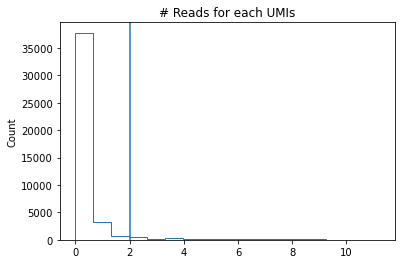

In [21]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_UMIs), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff2 = 2
plt.axvline(x=cutoff2)
plt.show()

In [23]:
cutoff2 = 2**cutoff2
print(cutoff2)

4


In [30]:
## counting total UMIs from dominant shRNA
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] >= threshold: ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
        if newUMI[0][0] < threshold: continue
    
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]
#        else:
#            print(newUMI)
        
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        poorUMI2.append(x)
        continue            
        
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1:
        if list(UMIpairs.values())[0] < cutoff2: 
            #print("Not past UMI Threshold: %s" % str(UMIpairs))
            poorUMI.append(UMIpairs)
            poorUMI2.append(x)
            continue
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort(reverse=True)
    if newUMI[0][0] < cutoff2: 
        #print("Not past second cutoff: %s" % str(UMIpairs))
        poorUMI.append(newUMI)
        poorUMI2.append(x)
        continue

    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI])

    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.15:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue

    poorUMI.append(newUMI)
    poorUMI2.append(x)

is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero


In [31]:
import statistics
sum(count)/len(count), min(count), max(count), statistics.median(count)

(13.150090780714141, 1, 2392, 1.0)

By UMI/Cell


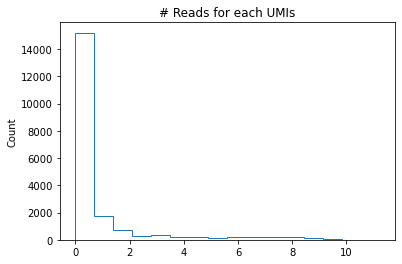

In [32]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(count), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
plt.show()

In [33]:
len(assignedCellshRNA)

1960

In [34]:
len(whitelist)

7114

In [35]:
#count.sort()
#count

In [36]:
len(poorUMI)

4605

In [37]:
poorUMI

[{('ACAGAGCC', 'GTCTGAAATACGTTGCATGAA'): 1},
 [(2, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')),
  (2, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')),
  (1, ('TTAATTAG', 'TGTTGAATTATTTTGTTGTAA')),
  (1, ('TTAATTAG', 'TCCTAAAATCCTTTCTATCAA')),
  (1, ('TTAATTAG', 'GGATGAACAAGGTTAGACTAA')),
  (1, ('TTAATTAG', 'GGAGGAATGAGGTTAGGAAAA')),
  (1, ('TTAATTAG', 'GGAGCAATTATGTTGTGAGAA')),
  (1, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')),
  (1, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')),
  (1, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')),
  (1, ('TGTCTAGT', 'GGGGGAATGGGTTTGTGGGAA')),
  (1, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')),
  (1, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')),
  (1, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')),
  (1, ('CGTTCAAG', 'CTAATAACAACATTCTACAAA')),
  (1, ('CGGGAATG', 'TGGTGAATGTTGTTGAATGAA')),
  (1, ('CGGGAATG', 'TAATCAAGGAAGTTATAGAAA')),
  (1, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')),
  (1, ('ACAGAGCC', 'GAATAAAGATGCTTCGAAGAA')),
  (1, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA')),
  (1, ('ACACGTGA', 'GGGGGAAGGGGGTTG

In [38]:
#calculate average hammandDistance
hdist = []
for x in poorUMI:
    if len(x) == 1:
#        hdist.append(0)
        continue
    y = [(z[1][0], z[1][1]) for z in x]
    pUMI = {}
    for z in y:
        if z[0] not in pUMI:
            pUMI[z[0]] = [z[1]]
        else:
            pUMI[z[0]].append(z[1])
    for y in pUMI:
        if len(pUMI[y]) < 2:
            continue
        for i in range(0, len(pUMI[y])):
            for j in range(i+1, len(pUMI[y])):
                hdist.append(hammingDistance(pUMI[y][i], pUMI[y][j]))
                if hammingDistance(pUMI[y][i], pUMI[y][j]) == 2:
                    print(pUMI[y])
                    print(pUMI[y][i], pUMI[y][j])

    

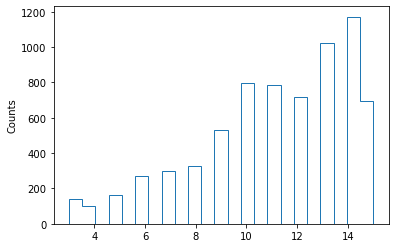

In [39]:
_ = plt.hist(hdist, bins='auto', histtype='step')

plt.ylabel("Counts")
plt.show()

#assign shRNA to barcodes with same shRNA virus
for x in range(len(poorUMI)):
    y = [z[1][0] for z in poorUMI[x]]
    if len(set(y)) == 1:
        assignedCellshRNA[poorUMI2[x]] = y[0]
        assignedCellbarcode[poorUMI2[x]] = "NA"

In [40]:
validshRNANameHash = {}
for x in assignedCellshRNA:
    validshRNANameHash[x] = hashes[assignedCellshRNA[x]]

In [41]:
len(assignedCellbarcode)

1960

In [42]:
import pandas as pd
pUMI = {}
for x in poorUMI2:
    pUMI[x] = 1
cellhashobj = pd.DataFrame.from_dict(pUMI, orient='index')
cellhashobj.rename(columns={0: "pUMI"}, inplace=True)
cellhashobj.to_pickle('pUMIcDNA.pickle')

In [43]:
import pandas as pd
  
cellhashobj = pd.DataFrame.from_dict(validshRNANameHash, orient='index')
cellhashobj.rename(columns={0: "shRNA"}, inplace=True)
cellhashobj.to_pickle('shRNAcDNA.pickle')

cellhashobj = pd.DataFrame.from_dict(assignedCellbarcode, orient='index')
cellhashobj.rename(columns={0: "barcode"}, inplace=True)
cellhashobj.to_pickle('barcodecDNA.pickle')

## END CODE HERE FOR NOW